In [21]:
# General
import xarray as xr    # handles netcdf data
import numpy as np     # numerical functions etc
import pandas as pd    # dataframes
import matplotlib      # plotting functions
import matplotlib.pyplot as plt    # specific plotting function I use a lot   
from matplotlib.patches import Rectangle     # specific plotting function with an annoyingly long name
import matplotlib.gridspec as gridspec #to define the sizes of plots specifically
import geopandas as gpd    # shapefiles
import cartopy     # plotting geographical features
from shapely.geometry import MultiPolygon, Polygon #to deal with 3D polygons
import regionmask    # convert shapefile to binary 0,1 mask
import re     # regular expressions (replace substrings etc)
from geopy.geocoders import Nominatim    # get lat & lon coordinates from a place name

#for climate indices
import xclim.indices as xc_i
import xclim as xc

#For plotting
import matplotlib.ticker as plticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import nc_time_axis #to plot cf.time axis
import cftime #to plot cf.time axis

#For Statistics
import scipy.stats as stats
from scipy import optimize
from xclim.indices.stats import fit
from scipy.stats import norm, gamma
import lmoments3.distr                     # conda activate xclim; pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo")

#For copulas
import sklarpy.univariate as sk_uni
from sklarpy.copulas import gh_copula
from sklarpy.multivariate import mvt_normal
from sklarpy.copulas import MarginalFitter
from sklarpy.univariate import UnivariateFitter
from sklarpy import print_full
from sklarpy.copulas import gumbel_copula
from sklarpy.copulas import frank_copula
from sklarpy.copulas import clayton_copula

#For handling errors
import sys
import warnings

### Load Data

In [2]:
dir_data = "/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/attribution/synthesis_files_climate_explorer/"

In [3]:
#SPEI-6
fn_spei6_historic  = dir_data + "synthesis_spei6_historic"
fn_spei6_ssp245  = dir_data + "synthesis_spei6_ssp245"
fn_spei6_ssp585  = dir_data + "synthesis_spei6_ssp585"

#SPEI-12
fn_spei12_historic  = dir_data + "synthesis_spei12_historic"
fn_spei12_ssp245  = dir_data + "synthesis_spei12_ssp245"
fn_spei12_ssp585  = dir_data + "synthesis_spei12_ssp585"

In [4]:
df_spei6_historic = pd.read_fwf(fn_spei6_historic, comment = "#", header = None, widths = [5,5,12,12,12,12,12,4,99], 
                 names = ["y0", "y1", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"], index_col = "model")
df_spei6_ssp245 = pd.read_fwf(fn_spei6_ssp245, comment = "#", header = None, widths = [5,5,12,12,12,12,12,4,99], 
                 names = ["y0", "y1", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"], index_col = "model")
df_spei6_ssp585 = pd.read_fwf(fn_spei6_ssp585, comment = "#", header = None, widths = [5,5,12,12,12,12,12,4,99], 
                 names = ["y0", "y1", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"], index_col = "model")

In [5]:
df_spei12_historic = pd.read_fwf(fn_spei12_historic, comment = "#", header = None, widths = [5,5,12,12,12,12,12,4,99], 
                 names = ["y0", "y1", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"], index_col = "model")
df_spei12_ssp245 = pd.read_fwf(fn_spei12_ssp245, comment = "#", header = None, widths = [5,5,12,12,12,12,12,4,99], 
                 names = ["y0", "y1", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"], index_col = "model")
df_spei12_ssp585 = pd.read_fwf(fn_spei12_ssp585, comment = "#", header = None, widths = [5,5,12,12,12,12,12,4,99], 
                 names = ["y0", "y1", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"], index_col = "model")

In [8]:
#Replace the names with better ones
df_array = [df_spei6_historic,df_spei6_ssp245,df_spei6_ssp585,df_spei12_historic,df_spei12_ssp245,df_spei12_ssp585]
for i in np.arange(0,6,1):
    df = df_array[i]
    df = df.rename(index={'"ACCESS-ESM1.5 (1) "': "ACCESS-ESM1.5"})
    df = df.rename(index={'"IPSL-CM6A-LR (1) "': "IPSL-CM6A-LR"})
    df = df.rename(index={'"MIROC6 (1) "': "MIROC6"})
    df = df.rename(index={'"MRI-ESM2-0 (1) "': "MRI-ESM2-0"})
    df = df.rename(index={'"NorESM2-LM (1) "': "NorESM2-LM"})
    df = df.rename(index={'"models "': "Model-Ensemble"})
    df_array[i] = df

### Plot the data

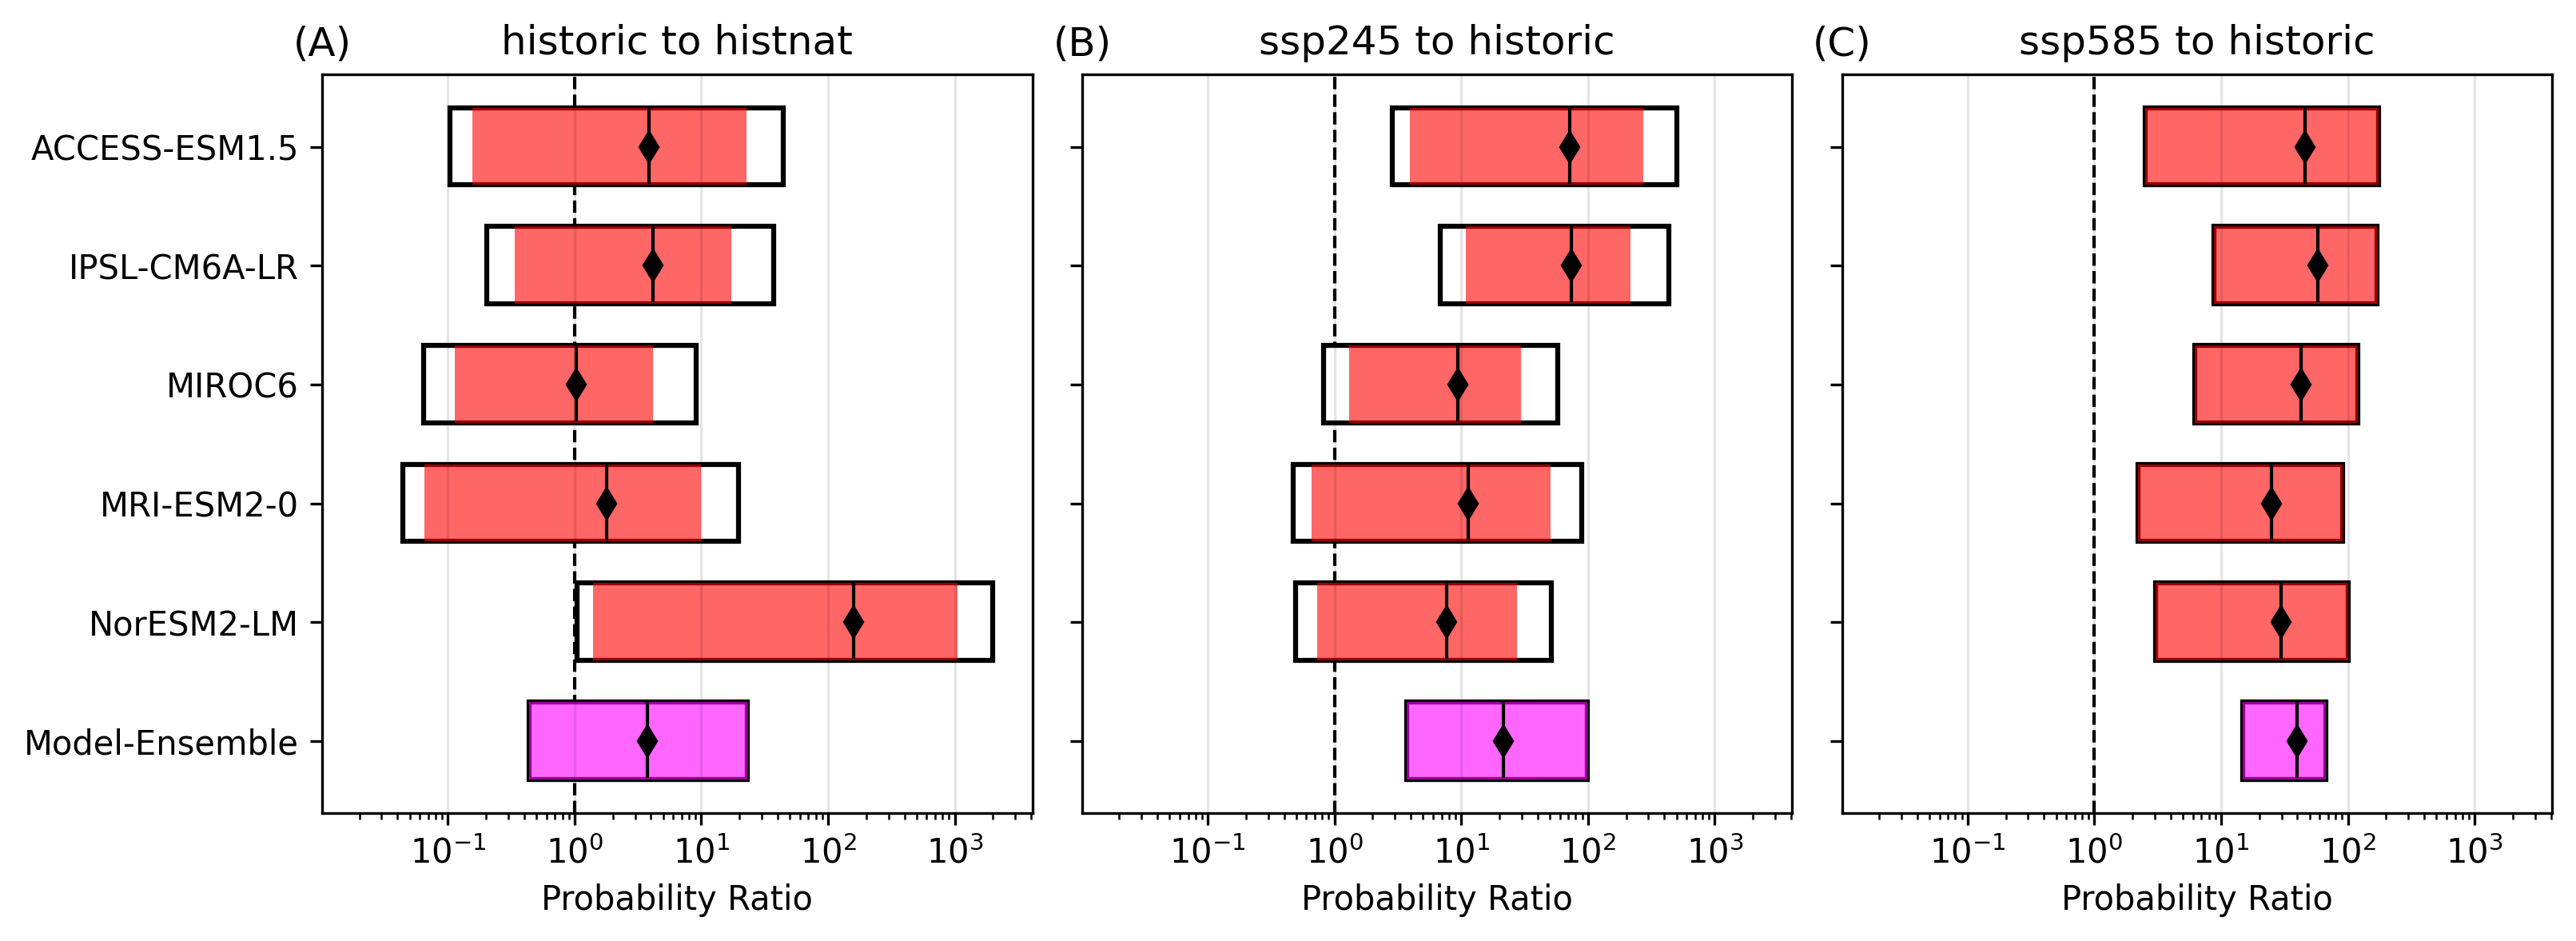

In [10]:
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (12,4), dpi = 300, sharey = "row", sharex = "col")
plt.subplots_adjust(wspace = 0.07, hspace = 0.1)

hist_ax = axs[0]; ssp1_ax = axs[1]; ssp2_ax = axs[2]


#ssp2_ax.axvline(0, ls = "--", color = "k", lw = 1, zorder = -99)

gcols = ["blue", "blue", "red", "magenta", "magenta"]
galpha = [0.5,1,0.6,0.6,1]

for i in range(3):
    ax = axs[i]
    ds = [df_array[0],df_array[1],df_array[2]]
    res = ds[i]
    ttl = [r"historic to histnat","ssp245 to historic","ssp585 to historic"]

    ax.set_title(ttl[i],fontsize='12')

    ax.grid(axis = "x", color = "k", alpha = 0.1, ls = "-", zorder = -99)

    for k in range(len(res)):

        r = res.iloc[k]
        ax.add_patch(Rectangle((r.l_wb,-k-0.32), r.u_wb - r.l_wb, 0.65, edgecolor = "k", facecolor = "w", lw = 1.5))
        ax.add_patch(Rectangle((r.lower,-k-0.32), r.upper - r.lower, 0.65, facecolor = gcols[int(r.group)-1], alpha = galpha[int(r.group)-1]))
        
        #ax.plot(r.est, -k+0.017, color="k", marker=custom_marker, linestyle='None', markersize=22.5)
        ax.plot(r.est, -k, color = "k", marker = "d")  
        ax.plot(r.est, -k, color = "k", marker = 2,markersize=12.5)
        ax.plot(r.est, -k, color = "k", marker = 3,markersize=11.)
            
hist_ax.axvline(1, ls = "--", color = "k", lw = 1, zorder = -99)
hist_ax.set_xscale('log') 
xx = [10**x for x in range(-4,10,1)]
hist_ax.set_xticks(xx)
#hist_ax.set_xticklabels([format(x,",") if not x in [10**6] else "" for x in xx])
hist_ax.set_yticks(range(0, -len(res), -1))
hist_ax.set_yticklabels([re.sub('"', '', r).strip() for r in res.index])
hist_ax.set_xlim(9.9**-2,8**4)
hist_ax.set_xlabel(r'Probability Ratio',fontsize='10')

ssp1_ax.axvline(1, ls = "--", color = "k", lw = 1, zorder = -99)
ssp1_ax.set_xscale('log') 
xx = [10**x for x in range(-4,10,1)]
ssp1_ax.set_xticks(xx)
#ssp1_ax.set_xticklabels([format(x,",") if not x in [10**6] else "" for x in xx])
ssp1_ax.set_xlim(9.9**-2,8**4)
ssp1_ax.set_xlabel(r'Probability Ratio',fontsize='10')

ssp2_ax.axvline(1, ls="--", color="k", lw=1, zorder=-99)
ssp2_ax.set_xscale('log')
xx = [10**x for x in range(-4, 10, 1)]
ssp2_ax.set_xticks(xx)
#ssp2_ax.set_xticklabels([format(x, ",") if x != 10**6 else "" for x in xx], fontsize=10)
ssp2_ax.set_xlim(9.9**-2,8**4)
ssp2_ax.set_xlabel(r'Probability Ratio',fontsize='10')

# Add subplot labels
labels = ['(A)', '(B)', '(C)']
for i, axes in enumerate(axs.flat):
    axes.annotate(labels[i], xy=(0, 1.0405), xycoords='axes fraction',
                  fontsize=12, ha='center', va='center')

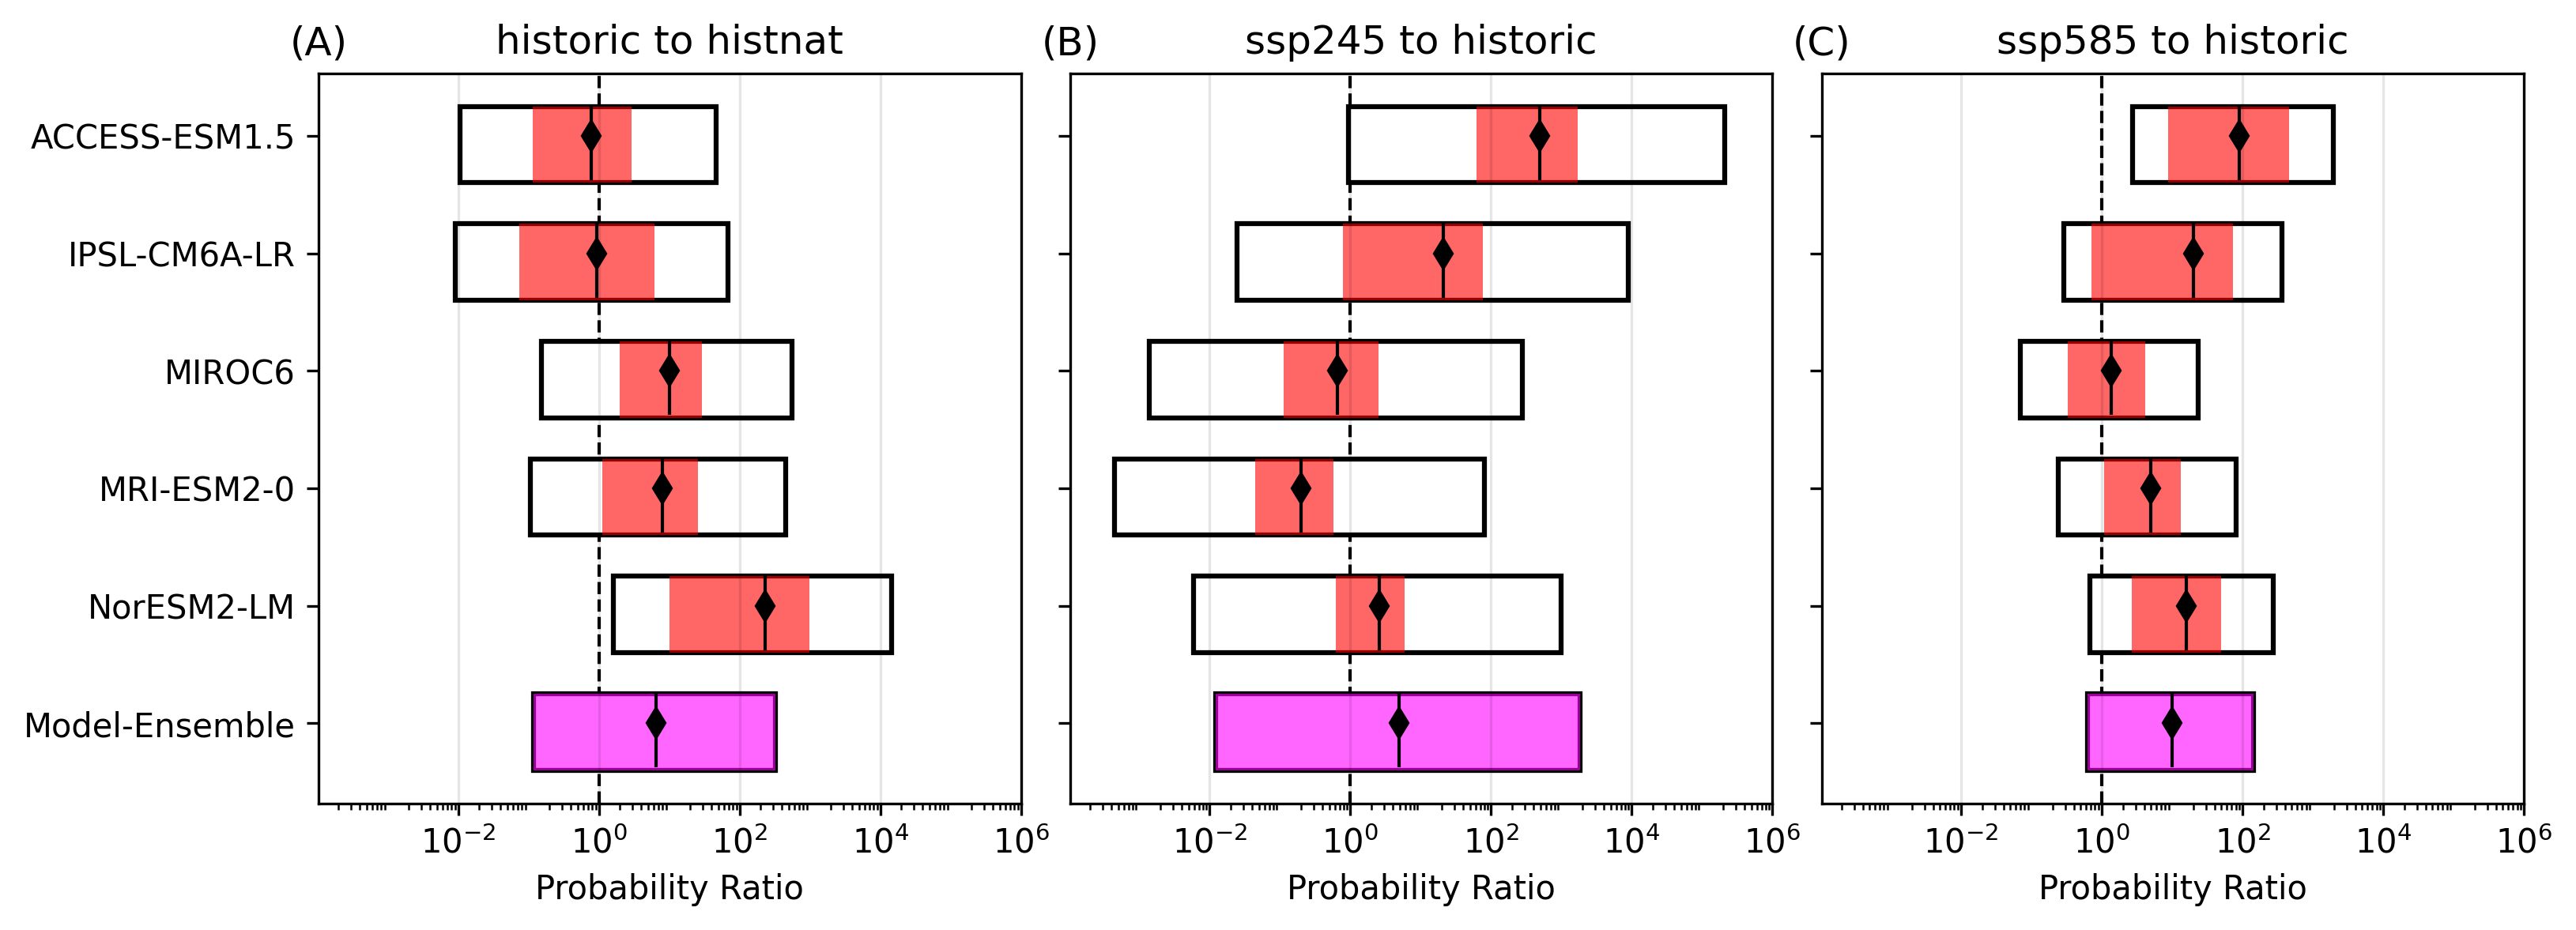

In [13]:
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (12,4), dpi = 300, sharey = "row", sharex = "col")
plt.subplots_adjust(wspace = 0.07, hspace = 0.1)

hist_ax = axs[0]; ssp1_ax = axs[1]; ssp2_ax = axs[2]


#ssp2_ax.axvline(0, ls = "--", color = "k", lw = 1, zorder = -99)

gcols = ["blue", "blue", "red", "magenta", "magenta"]
galpha = [0.5,1,0.6,0.6,1]

for i in range(3):
    ax = axs[i]
    ds = [df_array[3],df_array[4],df_array[5]]
    res = ds[i]
    ttl = [r"historic to histnat","ssp245 to historic","ssp585 to historic"]

    ax.set_title(ttl[i],fontsize='12')

    ax.grid(axis = "x", color = "k", alpha = 0.1, ls = "-", zorder = -99)

    for k in range(len(res)):

        r = res.iloc[k]
        ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.65, edgecolor = "k", facecolor = "w", lw = 1.5))
        ax.add_patch(Rectangle((r.lower,-k-0.4), r.upper - r.lower, 0.65, facecolor = gcols[int(r.group)-1], alpha = galpha[int(r.group)-1]))
        
        #ax.plot(r.est, -k+0.017, color="k", marker=custom_marker, linestyle='None', markersize=22.5)
        ax.plot(r.est, -k, color = "k", marker = "d")  
        ax.plot(r.est, -k, color = "k", marker = 2,markersize=9.5)
        ax.plot(r.est, -k, color = "k", marker = 3,markersize=13.5)
#axs[0].plot(r.iloc[1].est, -1, color = "k", marker = 2,markersize=10)
            
hist_ax.axvline(1, ls = "--", color = "k", lw = 1, zorder = -99)
hist_ax.set_xscale('log') 
xx = [10**x for x in range(-4,10,2)]
hist_ax.set_xticks(xx)
#hist_ax.set_xticklabels([format(x,",") if not x in [10**6] else "" for x in xx])
hist_ax.set_yticks(range(0, -len(res), -1))
#hist_ax.set_yticklabels([re.sub('"', '', r).strip() for r in res.index])
#hist_ax.set_yticks([i - 4.01 for i in range(len(res))])
hist_ax.set_yticklabels([re.sub('"', '', r).strip() for r in res.index])
hist_ax.set_xlim(9.9**-4,10**6)
hist_ax.xaxis.set_minor_locator(plticker.LogLocator(base=10.0, subs='auto', numticks=10))
hist_ax.set_xlabel(r'Probability Ratio',fontsize='10')

ssp1_ax.axvline(1, ls = "--", color = "k", lw = 1, zorder = -99)
ssp1_ax.set_xscale('log') 
xx = [10**x for x in range(-4,10,2)]
ssp1_ax.set_xticks(xx)
#ssp1_ax.set_xticklabels([format(x,",") if not x in [10**6] else "" for x in xx])
ssp1_ax.set_xlim(9.9**-4,10**6)
ssp1_ax.xaxis.set_minor_locator(plticker.LogLocator(base=10.0, subs='auto', numticks=10))
ssp1_ax.set_xlabel(r'Probability Ratio',fontsize='10')

ssp2_ax.axvline(1, ls="--", color="k", lw=1, zorder=-99)
ssp2_ax.set_xscale('log')
xx = [10**x for x in range(-4, 10, 2)]
ssp2_ax.set_xticks(xx)
#ssp2_ax.set_xticklabels([format(x, ",") if x != 10**6 else "" for x in xx], fontsize=9)
ssp2_ax.set_xlim(9.9**-4, 10**6)
ssp2_ax.xaxis.set_minor_locator(plticker.LogLocator(base=10.0, subs='auto', numticks=10))
ssp2_ax.set_xlabel(r'Probability Ratio',fontsize='10')

# Add subplot labels
labels = ['(A)', '(B)', '(C)']
for i, axes in enumerate(axs.flat):
    axes.annotate(labels[i], xy=(0, 1.0405), xycoords='axes fraction',
                  fontsize=12, ha='center', va='center')

### Print the Results

In [14]:
df_spei6_historic

,y0,y1,est,lower,upper,l_wb,u_wb,group
model,,,,,,,,
"""ACCESS-ESM1.5 (1) """,1900,2020,3.89,0.1570,22.70,0.1040,44.30,3
"""IPSL-CM6A-LR (1) """,1900,2020,4.18,0.3350,17.30,0.2020,37.50,3
"""MIROC6 (1) """,1900,2020,1.03,0.1140,4.17,0.0646,9.13,3
"""MRI-ESM2-0 (1) """,1900,2020,1.80,0.0655,9.95,0.0439,19.70,3
"""NorESM2-LM (1) """,1900,2020,159.00,1.3900,1050.00,1.0400,1980.00,3
"""models """,1900,2020,3.73,0.4400,23.10,0.4400,23.10,4


In [15]:
df_spei6_ssp245

,y0,y1,est,lower,upper,l_wb,u_wb,group
model,,,,,,,,
"""ACCESS-ESM1.5 (1) """,2020,2050,71.90,3.960,274.0,2.850,505.0,3
"""IPSL-CM6A-LR (1) """,2020,2050,73.60,10.900,217.0,6.810,438.0,3
"""MIROC6 (1) """,2020,2050,9.44,1.300,29.5,0.824,58.2,3
"""MRI-ESM2-0 (1) """,2020,2050,11.30,0.661,50.6,0.473,88.9,3
"""NorESM2-LM (1) """,2020,2050,7.72,0.734,27.6,0.495,51.8,3
"""models """,2020,2050,21.50,3.710,98.6,3.710,98.6,4


In [16]:
df_spei6_ssp585

,y0,y1,est,lower,upper,l_wb,u_wb,group
model,,,,,,,,
"""ACCESS-ESM1.5 (1) """,2020,2050,45.7,2.51,176.0,2.51,176.0,3
"""IPSL-CM6A-LR (1) """,2020,2050,58.1,8.75,169.0,8.75,169.0,3
"""MIROC6 (1) """,2020,2050,42.6,6.22,120.0,6.22,120.0,3
"""MRI-ESM2-0 (1) """,2020,2050,25.1,2.20,90.7,2.20,90.7,3
"""NorESM2-LM (1) """,2020,2050,29.7,3.03,100.0,3.03,100.0,3
"""models """,2020,2050,39.9,14.90,67.5,14.90,67.5,4


In [17]:
df_spei12_historic

,y0,y1,est,lower,upper,l_wb,u_wb,group
model,,,,,,,,
"""ACCESS-ESM1.5 (1) """,1900,2020,0.789,0.1160,2.89,0.0105,46.7,3
"""IPSL-CM6A-LR (1) """,1900,2020,0.925,0.0736,6.24,0.0091,69.0,3
"""MIROC6 (1) """,1900,2020,10.200,1.9800,29.40,0.1530,561.0,3
"""MRI-ESM2-0 (1) """,1900,2020,7.980,1.1300,25.50,0.1050,453.0,3
"""NorESM2-LM (1) """,1900,2020,233.000,10.1000,974.00,1.6000,14400.0,3
"""models """,1900,2020,6.440,0.1190,323.00,0.1190,323.0,4


In [19]:
df_spei12_ssp245

,y0,y1,est,lower,upper,l_wb,u_wb,group
model,,,,,,,,
"""ACCESS-ESM1.5 (1) """,2020,2050,496.000,62.9000,1720.000,0.951000,207000.0,3
"""IPSL-CM6A-LR (1) """,2020,2050,21.100,0.7750,77.300,0.024300,8940.0,3
"""MIROC6 (1) """,2020,2050,0.648,0.1120,2.540,0.001370,278.0,3
"""MRI-ESM2-0 (1) """,2020,2050,0.198,0.0444,0.575,0.000447,80.0,3
"""NorESM2-LM (1) """,2020,2050,2.580,0.6230,5.870,0.005930,1000.0,3
"""models """,2020,2050,4.880,0.0123,1830.000,0.012300,1830.0,4


In [20]:
df_spei12_ssp585

,y0,y1,est,lower,upper,l_wb,u_wb,group
model,,,,,,,,
"""ACCESS-ESM1.5 (1) """,2020,2050,90.90,8.710,462.00,2.7300,1960.0,3
"""IPSL-CM6A-LR (1) """,2020,2050,19.90,0.714,73.20,0.2900,367.0,3
"""MIROC6 (1) """,2020,2050,1.37,0.328,4.11,0.0701,23.2,3
"""MRI-ESM2-0 (1) """,2020,2050,4.91,1.090,13.40,0.2410,80.3,3
"""NorESM2-LM (1) """,2020,2050,16.00,2.650,49.60,0.6740,274.0,3
"""models """,2020,2050,9.87,0.625,142.00,0.6250,142.0,4
